# Asimov significance

Using `v6_sig` templates which only has MCstats unc. and the top+wjets rate constraints.

Note: all significance values are after combination with the topCR and the wjetsCR).

In [1]:
import glob
import os
import json
import pickle
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'had': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [4]:
def get_lumi(years, channels):
    lum_ = 0
    for year in years:
        lum = 0
        for ch in channels:
            lum += luminosity[ch][year] / 1000.0

        lum_ += lum / len(channels)    
    return lum_

In [5]:
! ls ../combine/templates/v6_sig/

hists_templates_Run2.pkl


In [6]:
# get lumi
import pickle as pkl
with open("../combine/templates/v6_sig/hists_templates_Run2.pkl", "rb") as f:    
    h = pkl.load(f)

In [7]:
h

Hist(
  StrCategory(['VBF', 'Data', 'EWKvjets', 'WH', 'WJetsLNu', 'TTbar', 'SingleTop', 'ggF', 'DYJets', 'Diboson', 'WZQQ', 'ttH', 'ZH', 'Fake'], growth=True, name='Sample'),
  StrCategory(['nominal', 'FR_stat_Up', 'FR_stat_Down', 'EWK_SF_Up', 'EWK_SF_Down'], growth=True, name='Systematic'),
  StrCategory(['WJetsCR', 'TopCR', 'ParT9999', 'ParT9995', 'ParT999', 'ParT995', 'ParT99', 'ParT985', 'ParT98', 'ParT975', 'ParT97', 'ParT965', 'ParT96', 'ParT955', 'ParT95', 'ParT945', 'ParT94', 'THWW99', 'THWW985', 'THWW98', 'THWW975', 'THWW97', 'THWW965', 'THWW96', 'THWW955', 'THWW95', 'THWW945', 'THWW94', 'THWW935', 'THWW93', 'THWW925', 'THWW92', 'THWW915', 'THWW91', 'THWW905', 'THWW90', 'ggF95', 'ggF945', 'ggF94', 'ggF935', 'ggF93', 'ggF925', 'ggF92', 'ggF915', 'ggF91', 'ggF905', 'ggF90', 'ggF895', 'ggF89', 'ggF885', 'ggF88', 'VBF92', 'VBF915', 'VBF91', 'VBF905', 'VBF90', 'VBF895', 'VBF89', 'ggF95pt250to350', 'ggF95pt350to500', 'ggF95pt500toInf', 'ggF945pt250to350', 'ggF945pt350to500', 'ggF945

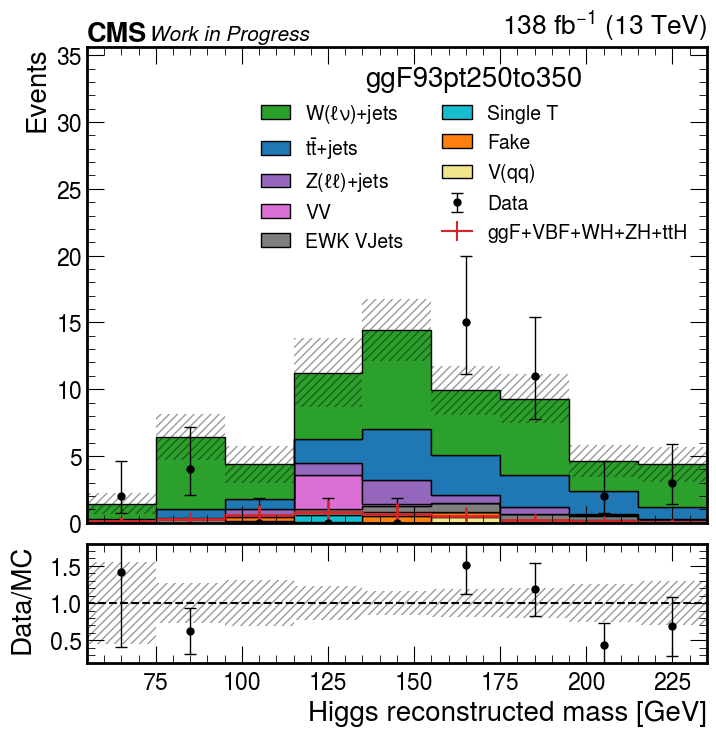

In [13]:
plt.rcParams.update({"font.size": 20})

region = "ggF93pt250to350"
systematic = "nominal"

text = region

blind_region=[100,150]
mult = 1

if "CR" in region:
    blind_region = False
    mult=1

years = ["2018", "2017", "2016", "2016APV"]
channels = ["ele", "mu"]

from utilsCombine import plot_hists
from utilsCombine2 import plot_hists

plot_hists(h[{"Systematic": systematic, "Region": region}], years, channels,
            add_data=True,
            logy=False,
            add_soverb=True,
            only_sig=False,
            mult=mult,
            outpath=f"/Users/fmokhtar/Desktop/AN_2024/combine/",
           save_as=region,
           text_=text,
           blind_region=blind_region,
          )

# ParT vs Part-Finetuned

In [19]:
##### they are combined with the topCR and the wjetsCR

tagger_cuts_ParT = [
    0.96,
    0.965,    
    0.97,
    0.975,
    0.98,
    0.985,
    0.99,
    0.995,
    0.999,
    0.9995,
    0.9999,    
]
sig_ParT = [
    0.799499,   # 0.96
    0.802389,   # 0.965    
    0.821361,   # 0.97
    0.830621,   # 0.975    
    0.836821,   # 0.98
    0.878923,   # 0.985
    0.902171,   # 0.99
    0.928209,   # 0.995
    1.01669,   # 0.999
    0.928467,   # 0.9995
    0.684986,   # 0.9999
]

tagger_cuts_ParT_finetuned = [
    0.90,
    0.905,
    0.91,
    0.915,
    0.92,
    0.925,
    0.93,
    0.935,
    0.94,
    0.945,    
    0.95,
    0.955,
    0.96,
    0.965,
    0.97,
]
sig_ParT_finetuned = [
    1.55463,   # 0.90
    1.60065,   # 0.905
    1.64092,   # 0.91
    1.66766,   # 0.915
    1.69878, # 0.92
    1.71196, # 0.925
    1.73188,   # 0.93
    1.7357,   # 0.935
    1.74848,   # 0.94
    1.73441,   # 0.945    
    1.69986,   # 0.95
    1.64245,   # 0.955
    1.63126,   # 0.96
    1.52299,   # 0.965    
    1.43623,   # 0.97
]

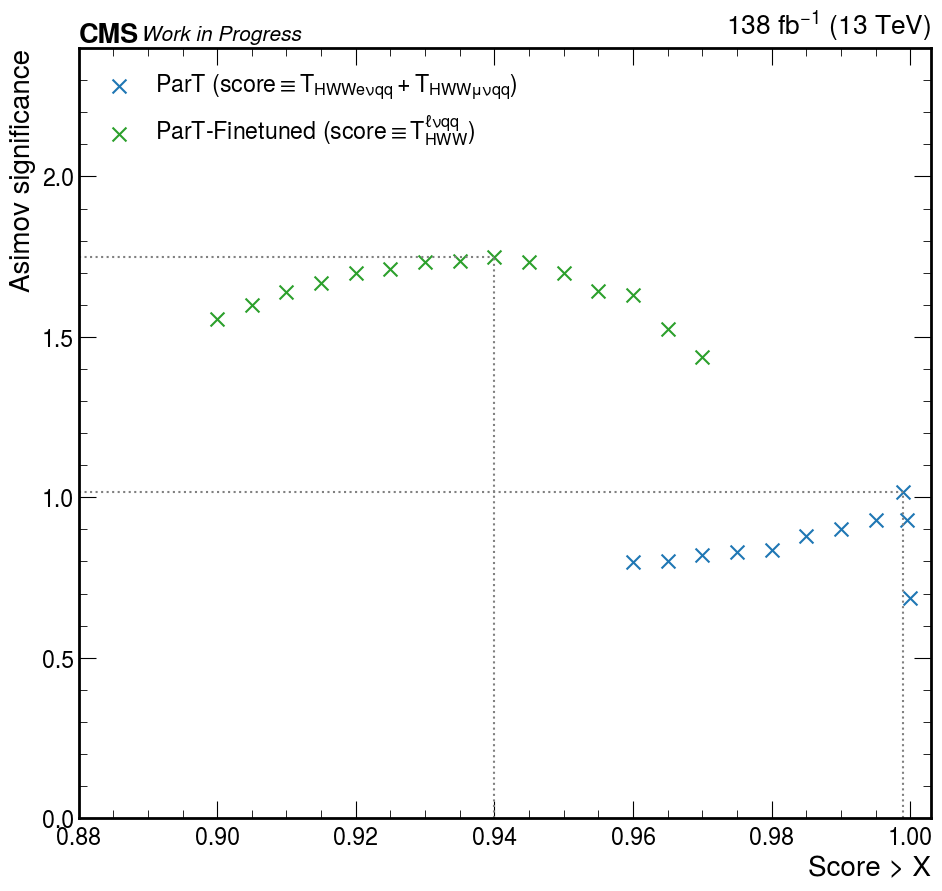

In [21]:
color_dict = {    
    "fj_ParT_score": "tab:blue",
    "fj_ParT_score_finetuned": "tab:green",   
}

lab_dict = {    
    "fj_ParT_score": r"ParT ($score \equiv T_{HWW e \nu q q} +T_{HWW \mu \nu q q}$)",
    "fj_ParT_score_finetuned": r"ParT-Finetuned ($score \equiv T_{HWW}^{\ell\nu qq}$)",
}


plt.rcParams.update({"font.size": 20})


years = ["2018", "2017", "2016APV", "2016"]
channels = ["ele", "mu"]

fig, ax = plt.subplots(figsize=(11, 10))


ax.scatter(tagger_cuts_ParT, sig_ParT, marker="x", s=100, label=lab_dict["fj_ParT_score"], color=color_dict["fj_ParT_score"])    
ax.scatter(tagger_cuts_ParT_finetuned, sig_ParT_finetuned, marker="x", s=100, label=lab_dict["fj_ParT_score_finetuned"], color=color_dict["fj_ParT_score_finetuned"])

# ax.axhline(1.50482, color="grey", linestyle="--")
# ax.axhline(0.882643, color="grey", linestyle="--")

ax.set_ylim(0.3, 1.8)
ax.legend(loc="upper left")
ax.set_ylabel("Asimov significance")
ax.set_xlabel("Score > X")

x1 = 0.88
x2 = 1.003
y1 = 0
y2 = 2.4

ax.set_xlim(x1, x2)
ax.set_ylim(y1, y2)

####### ParT
wp = 0.999
sig = 1.01669
ax.plot([wp, wp], [y1, sig], ':', color='grey')
ax.plot([x1, wp], [sig, sig], ':', color='grey')

####### ParT_finetuned
wp = 0.94
sig = 1.74848
ax.plot([wp, wp], [y1, sig], ':', color='grey')
ax.plot([x1, wp], [sig, sig], ':', color='grey')

hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/significance/sig_ParTvsParTFinetuned.pdf")

# Should we categorize?

In [22]:
# ##### they are combined with the topCR and the wjetsCR

# tagger_cuts = [
#     0.90,
#     0.905,
#     0.91,
#     0.915,
#     0.92,
#     0.925,
#     0.93,
#     0.935,
#     0.94,
#     0.945,    
#     0.95,
#     0.955,
#     0.96,
#     0.965,
#     0.97,
# ]

# # without ggF and VBF splitting
# sig = [
#     1.55463,   # 0.90
#     1.60065,   # 0.905
#     1.64092,   # 0.91
#     1.66766,   # 0.915
#     1.69878, # 0.92
#     1.71196, # 0.925
#     1.73188,   # 0.93
#     1.7357,   # 0.935
#     1.74848,   # 0.94
#     1.73441,   # 0.945    
#     1.69986,   # 0.95
#     1.64245,   # 0.955
#     1.63126,   # 0.96
#     1.52299,   # 0.965    
#     1.43623,   # 0.97
# ]

# tagger_cuts_ggFandVBF = [
#     0.90,
#     0.905,
#     0.91,
#     0.915,
#     0.92,
# ]

# # with ggF and VBF splitting
# sig_ggFandVBF = [
#     ,   # 0.90
#     ,   # 0.905
#     ,   # 0.91
#     ,   # 0.915
#     , # 0.92
# ]

In [23]:
# color_dict = {    
#     "fj_ParT_score": "tab:blue",
#     "fj_ParT_score_finetuned": "tab:green",   
# }

# lab_dict = {    
#     "fj_ParT_score": "ParT",
#     "fj_ParT_score_finetuned": "ParT-finetuned",
# }


# plt.rcParams.update({"font.size": 20})

# years = ["2018", "2017", "2016APV", "2016"]
# channels = ["ele", "mu"]

# fig, ax = plt.subplots(figsize=(11, 10))

# ax.scatter(tagger_cuts, sig, marker="x", s=100, label="Before VBF-ggF categorization")
# ax.scatter(tagger_cuts_ggFandVBF, sig_ggFandVBF, marker="x", s=100, label="After VBF-ggF categorization")

# # ax.plot([0.975, 0.975], [0.3, 2.00251], ':', color='grey')
# # ax.plot([0.3, 0.975], [2.00251, 2.00251], ':', color='grey')

# # ax.plot([0.985, 0.985], [0.3, 1.67914], ':', color='grey')
# # ax.plot([0.3, 0.985], [1.67914, 1.67914], ':', color='grey')

# # ax.set_xlim(0.956, 0.989)
# # ax.set_ylim(0.88, 2.4)

# ax.set_ylim(1.4, 2.4)
# ax.legend()
# ax.set_ylabel("Asimov significance")
# ax.set_xlabel(r"$T_{HWW}^{\ell\nu qq} > X$")

# # ax.set_xticks(tagger_cuts)

# hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
# hep.cms.text("Work in Progress", ax=ax, fontsize=15)
# plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/significance/significance_VBFggFcategorization.pdf")

# WP1 (ggF and VBF)

In [26]:
##### they are combined with the topCR and the wjetsCR

tagger_cuts_vbf = [
    0.89,
    0.895,    
    0.90,
    0.905,
    0.91,    
    0.915,
    0.92,
]
sig_vbf = [
    1.47286,   # 0.89
    1.51192,   # 0.895    
    1.53364,   # 0.90
    1.58084,   # 0.905
    1.56861,   # 0.91
    1.55617,   # 0.915
    1.51708,   # 0.92     
]

tagger_cuts = [
    0.90,
    0.905,
    0.91,    
    0.915,
    0.92,
    0.925,
    0.93,
    0.935,
    0.94,
    0.945,    
    0.95,
]
   
sig_ggf_pt250to350 = [
    0.724758,   # 0.90
    0.736967,   # 0.905
    0.739716,   # 0.91
    0.741465,   # 0.915
    0.757475,   # 0.92
    0.755545,   # 0.925
    0.749764,   # 0.93
    0.755376,   # 0.935
    0.759968,   # 0.94
    0.749067,   # 0.945
    0.741257,   # 0.95
]
sig_ggf_pt350to500 = [
    1.04911,   # 0.90
    1.07496,   # 0.905
    1.10616,   # 0.91
    1.12288,   # 0.915
    1.14509,   # 0.92
    1.14512,   # 0.925
    1.15062,   # 0.93
    1.14819,   # 0.935
    1.16609,   # 0.94
    1.14112,   # 0.945
    1.11913,   # 0.95
]
sig_ggf_pt500toInf = [
    0.776134,   # 0.90
    0.783228,   # 0.905
    0.797485,   # 0.91
    0.806319,   # 0.915
    0.81185,   # 0.92
    0.816469,   # 0.925
    0.844009,   # 0.93
    0.841999,   # 0.935
    0.840435,   # 0.94
    0.826621,   # 0.945
    0.812973,   # 0.95
]

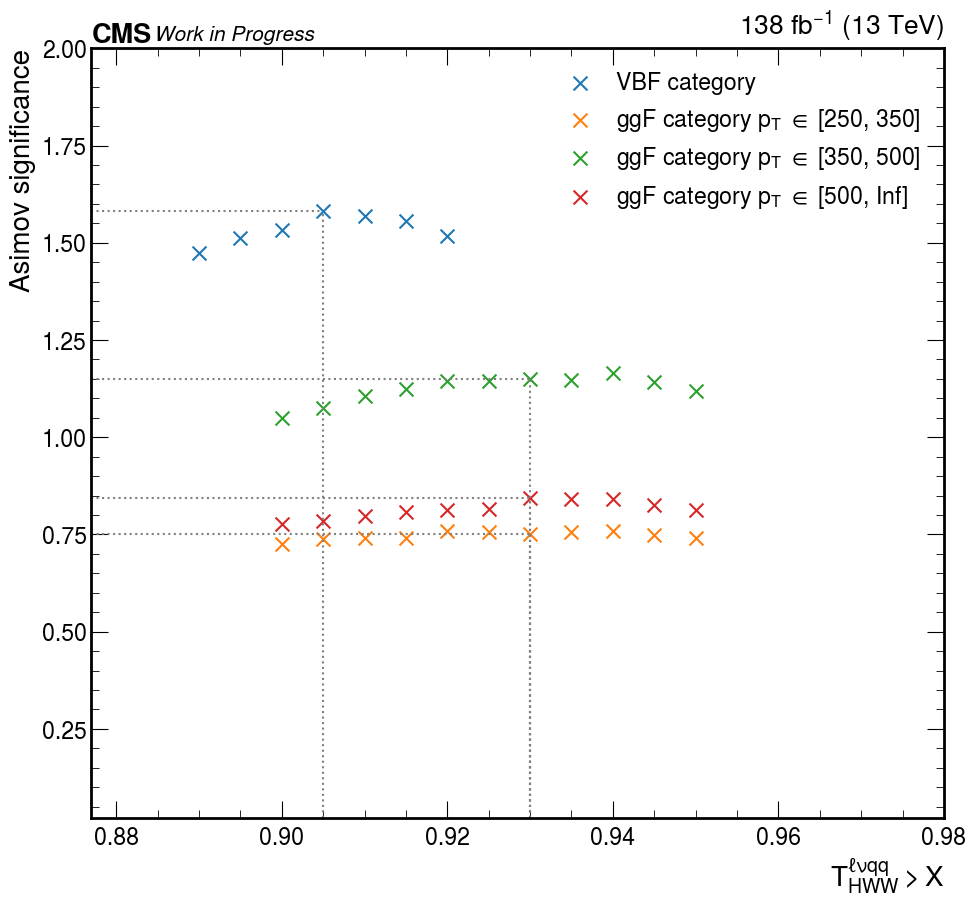

In [28]:
color_dict = {    
    "fj_ParT_score": "tab:blue",
    "fj_ParT_score_finetuned": "tab:green",   
}

lab_dict = {    
    "fj_ParT_score": "ParT",
    "fj_ParT_score_finetuned": "ParT-finetuned",
}


plt.rcParams.update({"font.size": 20})

years = ["2018", "2017", "2016APV", "2016"]
channels = ["ele", "mu"]

fig, ax = plt.subplots(figsize=(11, 10))

for tagger in [
#     "fj_ParT_score",
    "fj_ParT_score_finetuned",
]:
    ax.scatter(tagger_cuts_vbf, sig_vbf, marker="x", s=100, label="VBF category")
    ax.scatter(tagger_cuts, sig_ggf_pt250to350, marker="x", s=100, label=r"ggF category $p_T$ $\in$ [250, 350]")
    ax.scatter(tagger_cuts, sig_ggf_pt350to500, marker="x", s=100, label=r"ggF category $p_T$ $\in$ [350, 500]")
    ax.scatter(tagger_cuts, sig_ggf_pt500toInf, marker="x", s=100, label=r"ggF category $p_T$ $\in$ [500, Inf]")

    
x1 = 0.877
y1 = 0.02
ax.set_xlim(x1, 0.98)
ax.set_ylim(y1, 2)

####### VBF
wp = 0.905
sig = 1.58084
ax.plot([wp, wp], [y1, sig], ':', color='grey')
ax.plot([x1, wp], [sig, sig], ':', color='grey')

####### ggFpt250to300
wp = 0.93
sig = 0.749764
ax.plot([wp, wp], [y1, sig], ':', color='grey')
ax.plot([x1, wp], [sig, sig], ':', color='grey')

####### ggFpt300to450
wp = 0.93
sig = 1.15062
ax.plot([wp, wp], [y1, sig], ':', color='grey')
ax.plot([x1, wp], [sig, sig], ':', color='grey')

####### ggFpt450toInf
wp = 0.93
sig = 0.844009
ax.plot([wp, wp], [y1, sig], ':', color='grey')
ax.plot([x1, wp], [sig, sig], ':', color='grey')

ax.legend()
ax.set_ylabel("Asimov significance")
ax.set_xlabel(r"$T_{HWW}^{\ell\nu qq} > X$")

# ax.set_xticks([0.9, 0.92, 0.94, 0.96, 0.97, 0.98])

# ax.set_xticks(tagger_cuts)


hep.cms.lumitext("%.0f " % get_lumi(years, channels) + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/AN_2024/significance/significanceWP.pdf")